In [140]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
import tensorflow as tf
from tqdm import tqdm

%matplotlib inline

# Loading & Data Visualization

In [141]:
train_df = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test_df = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')
print(train_df.shape)
print(test_df.shape)
train_df.head()

(3662, 2)
(1928, 1)


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

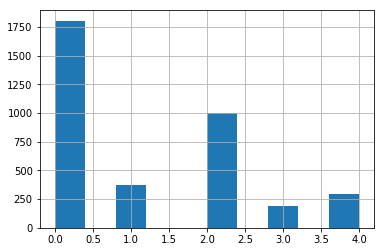

In [142]:
train_df['diagnosis'].hist()
train_df['diagnosis'].value_counts()

### Sample Images from train dataset

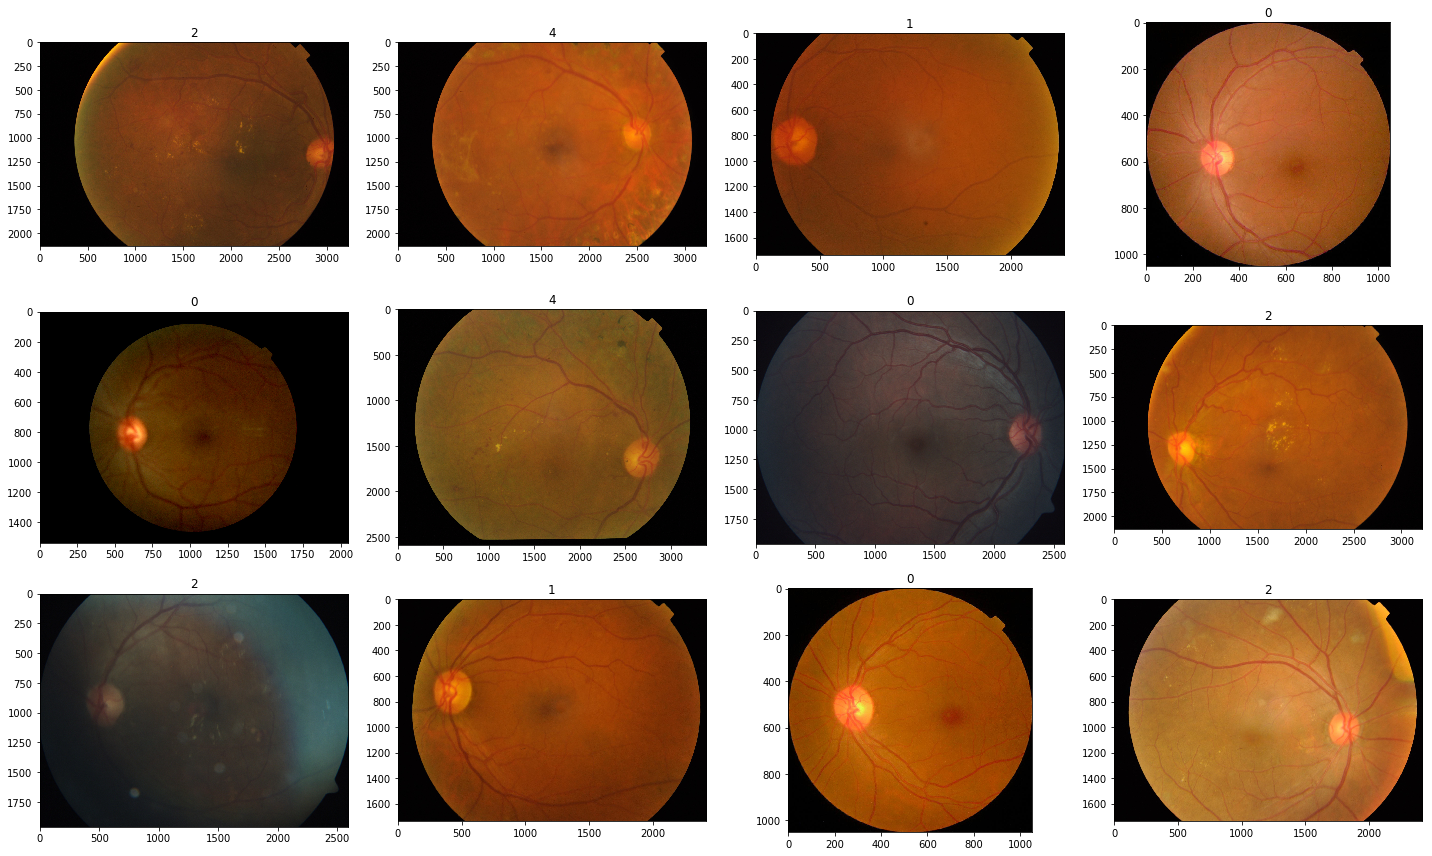

In [143]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = cv2.imread(f'../input/aptos2019-blindness-detection/train_images/{image_path}.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(train_df)

# Resizing Images


In [144]:
def preprocess_image(image_path, desired_size=224):
    im = Image.open(image_path)
    im = im.resize((desired_size, )*2, resample=Image.LANCZOS)
    
    return im

In [145]:
N = train_df.shape[0]
x_train = np.empty((N, 224, 224, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(train_df['id_code'])):
    x_train[i, :, :, :] = preprocess_image(
        f'../input/aptos2019-blindness-detection/train_images/{image_id}.png'
    )


 12%|█▏        | 447/3662 [01:11<07:33,  7.09it/s]


 25%|██▍       | 898/3662 [02:20<08:07,  5.67it/s]


 37%|███▋      | 1337/3662 [03:27<06:01,  6.44it/s]


 49%|████▉     | 1802/3662 [04:36<03:31,  8.81it/s]


 62%|██████▏   | 2275/3662 [05:45<03:49,  6.04it/s]


 75%|███████▌  | 2760/3662 [06:53<02:08,  7.03it/s]


 88%|████████▊ | 3218/3662 [08:00<00:57,  7.67it/s]


100%|██████████| 3662/3662 [09:04<00:00,  6.07it/s]

In [146]:
N = test_df.shape[0]
x_test = np.empty((N, 224, 224, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(test_df['id_code'])):
    x_test[i, :, :, :] = preprocess_image(
        f'../input/aptos2019-blindness-detection/test_images/{image_id}.png'
    )


 68%|██████▊   | 1315/1928 [01:04<00:29, 20.81it/s]


100%|██████████| 1928/1928 [01:41<00:00, 19.04it/s]

In [147]:
y_train = pd.get_dummies(train_df['diagnosis']).values

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

(3662, 224, 224, 3)
(3662, 5)
(1928, 224, 224, 3)


## Creating multilabels for the images


In [148]:
y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_multi[:, 4] = y_train[:, 4]

for i in range(3, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

print("Original y_train:", y_train.sum(axis=0))
print("Multilabel version:", y_train_multi.sum(axis=0))

Original y_train: [1805  370  999  193  295]
Multilabel version: [3662 1857 1487  488  295]


In [149]:
np.random.seed(2019)
tf.set_random_seed(2019)

Now we can split it into a training and validation set.

In [150]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train_multi, 
    test_size=0.15, 
    random_state=2019
)

# Data Generator

In [151]:
BATCH_SIZE = 32

def create_datagen():
    return ImageDataGenerator(
        zoom_range=0.15,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

# Using original generator
data_generator = create_datagen().flow(x_train, y_train, batch_size=BATCH_SIZE, seed=2019)

# Loading Model -> DenseNet-121

In [152]:
densenet = DenseNet121(
    weights='../input/densenet-keras/DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=(224,224,3)
)

In [153]:
def build_model():
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=0.00005),
        metrics=['accuracy']
    )
    
    return model

In [154]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1024)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 5125      
Total params: 7,042,629
Trainable params: 6,958,981
Non-trainable params: 83,648
_________________________________________________________________


# Training & Evaluating 

In [155]:

history = model.fit_generator(
    data_generator,
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=15,
    validation_data=(x_val, y_val),
    verbose=2
)

Epoch 1/15
 - 95s - loss: 0.4501 - acc: 0.7912 - val_loss: 0.2545 - val_acc: 0.9262
Epoch 2/15
 - 41s - loss: 0.2072 - acc: 0.9244 - val_loss: 0.1615 - val_acc: 0.9393
Epoch 3/15
 - 44s - loss: 0.1633 - acc: 0.9396 - val_loss: 0.1199 - val_acc: 0.9553
Epoch 4/15
 - 43s - loss: 0.1459 - acc: 0.9440 - val_loss: 0.1032 - val_acc: 0.9640
Epoch 5/15
 - 42s - loss: 0.1323 - acc: 0.9509 - val_loss: 0.1019 - val_acc: 0.9618
Epoch 6/15
 - 43s - loss: 0.1186 - acc: 0.9552 - val_loss: 0.1039 - val_acc: 0.9625
Epoch 7/15
 - 43s - loss: 0.1125 - acc: 0.9560 - val_loss: 0.1025 - val_acc: 0.9633
Epoch 8/15
 - 43s - loss: 0.1038 - acc: 0.9596 - val_loss: 0.1051 - val_acc: 0.9596
Epoch 9/15
 - 42s - loss: 0.1014 - acc: 0.9618 - val_loss: 0.1026 - val_acc: 0.9611
Epoch 10/15
 - 43s - loss: 0.0950 - acc: 0.9628 - val_loss: 0.0956 - val_acc: 0.9636
Epoch 11/15
 - 43s - loss: 0.0870 - acc: 0.9670 - val_loss: 0.0947 - val_acc: 0.9684
Epoch 12/15
 - 42s - loss: 0.0828 - acc: 0.9668 - val_loss: 0.1007 - val_a

In [156]:
model.save_weights('model_1.h5')

model_json = model.to_json()
with open('model_1.json', 'w') as json_file:
    json_file.write(model_json)
    
print('Model saved to the disk.')

Model saved to the disk.


In [ ]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

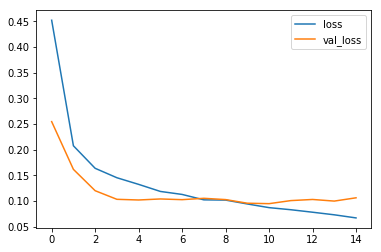

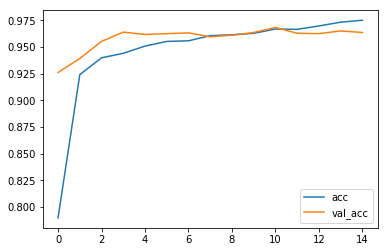

In [157]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

## Saving and Predicting

In [165]:
model.load_weights('model_1.h5')
y_test = model.predict(x_test) > 0.5
y_test = y_test.astype(int)

In [166]:
y_test = y_test.astype(int).sum(axis=1) - 1

test_df['diagnosis'] = y_test
test_df.to_csv('submission_1.csv',index=False)

In [167]:
print(y_test)

[2 2 2 ... 2 3 0]


In [168]:
submission_df=pd.read_csv('/kaggle/working/submission_1.csv')

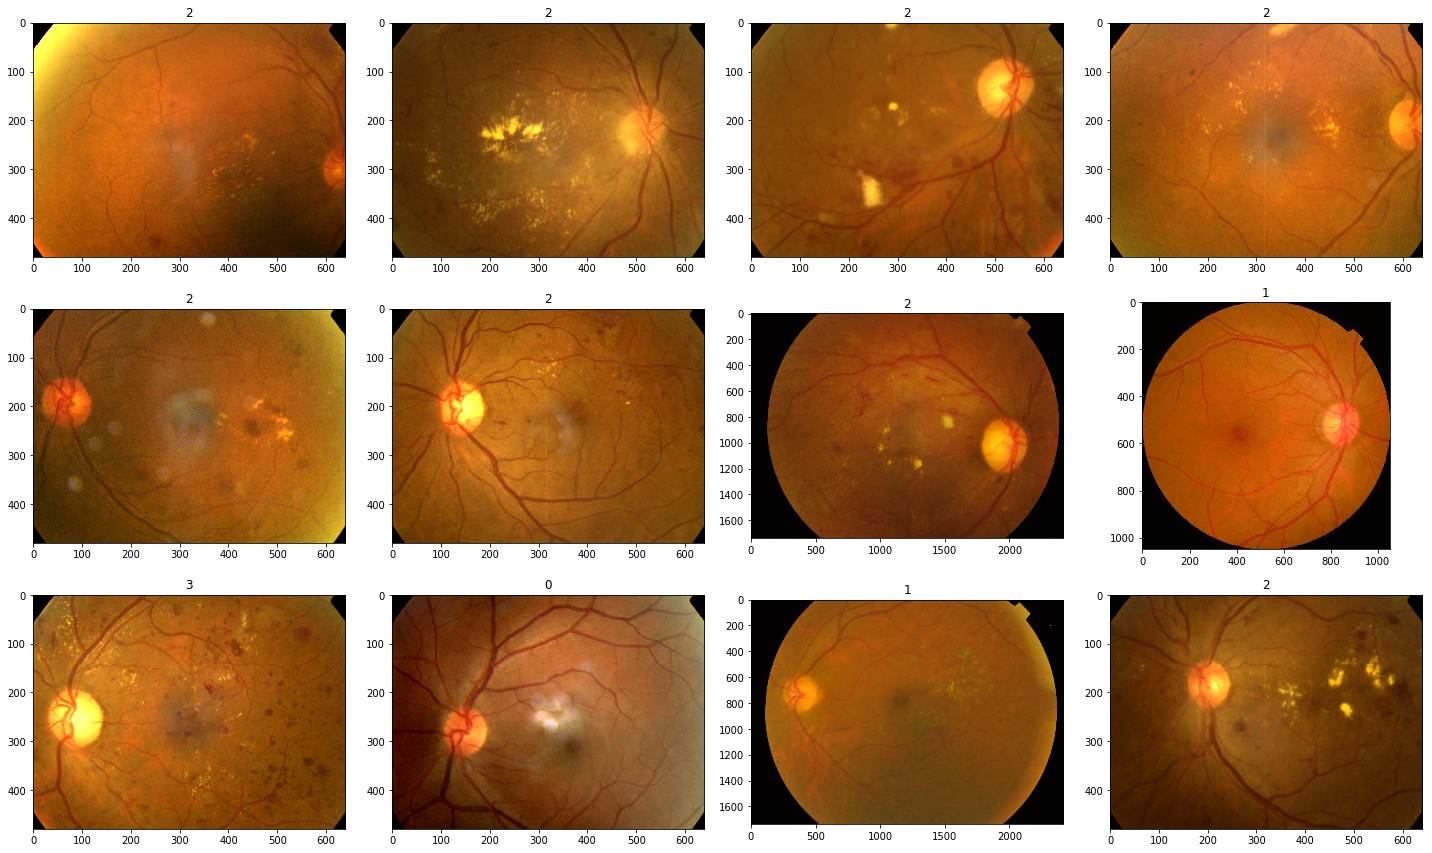

In [169]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = cv2.imread(f'../input/aptos2019-blindness-detection/test_images/{image_path}.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(submission_df)

In [170]:
IMG = Image.open(f'../input/aptos2019-blindness-detection/test_images/01e4d86b3a30.png')
print(type(IMG))
IMG = IMG.resize((224, 224))
IMG = np.array(IMG)
print('array = {}'.format(IMG.shape))
IMG = IMG.reshape(1, 224, 224, 3)
print(type(IMG), IMG.shape)


<class 'PIL.PngImagePlugin.PngImageFile'>
array = (224, 224, 3)
<class 'numpy.ndarray'> (1, 224, 224, 3)


In [171]:
y_pred = model.predict(IMG) > 0.5

In [172]:
y_pred = y_pred.astype(int)

In [173]:
y_pred = y_pred.astype(int).sum(axis=1) - 1
if(y_pred==0):
    print("No Diabetic Retinopathy")
elif(y_pred==1):
    print("Mild Diabetic Retinopathy")
elif(y_pred==2):
    print("Moderate Diabetic Retinopathy")
elif(y_pred==3):
    print("Severe Diabetic Retinopathy")
else:
    print("Proliferative Diabetic Retinopathy")

Mild Diabetic Retinopathy
